In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_excel("data/Data_2024.xlsx", sheet_name="Data_regrese")
df = df.rename(columns={
    "OSType": "os",
    "ActiveUsers": "actusers",
    "InteractingPct": "interact",
    "ScrollingPct": "scroll",
    "Ping [ms]": "ping"
}, errors="raise")
df = df.drop(labels=[255, 476], axis="index")

print(df.columns)

Index(['os', 'actusers', 'interact', 'scroll', 'ping'], dtype='object')


In [3]:
formula = "ping ~ interact + C(os)+ I(actusers**2) + actusers:interact + actusers:C(os)"

model = smf.ols(formula=formula, data=df)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.28e-215
Time:                        19:53:27   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [4]:
dfS = df.copy()
dfS[["actusers", "interact"]] = (dfS[["actusers", "interact"]]-dfS[[
    "actusers", "interact"]].mean())/dfS[["actusers", "interact"]].std()


model2 = smf.ols(formula=formula, data=dfS)
results2 = model2.fit()

print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.28e-215
Time:                        19:53:27   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

                                0
Intercept                5.523135
C(os)[T.MacOS]           1.633288
C(os)[T.Windows]         1.621820
C(os)[T.iOS]             1.594420
interact                 1.015158
I(actusers ** 2)         1.016231
actusers:interact        1.021621
actusers:C(os)[Android]  1.016072
actusers:C(os)[MacOS]    1.008560
actusers:C(os)[Windows]  1.004114
actusers:C(os)[iOS]      1.023536


<Axes: >

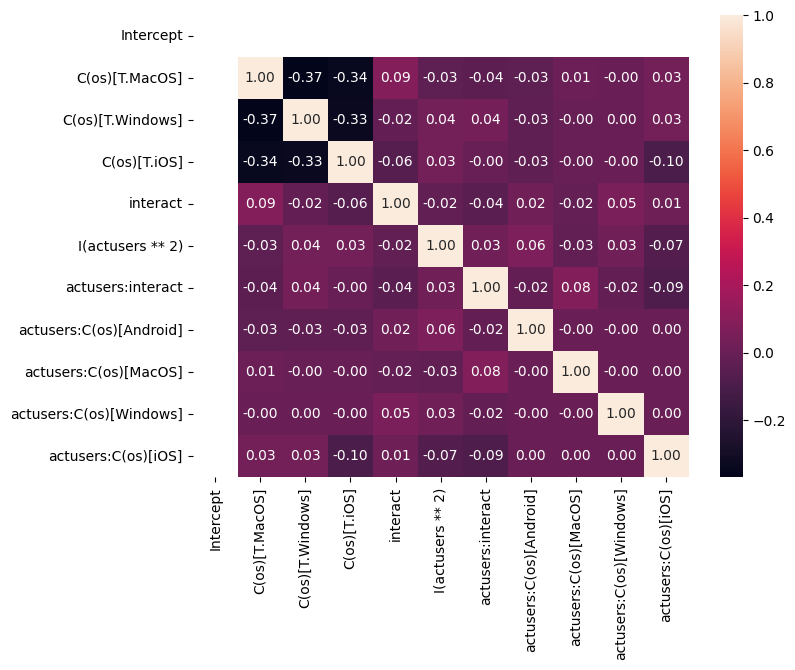

In [5]:

X = pd.DataFrame(model2.exog, columns=model2.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                index=X.columns)
print(vif.to_frame())

df_corr = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, fmt=".2f")

In [6]:
influence = results2.get_influence()
leverage = influence.hat_matrix_diag
cooks_d, cooks_d_pval = influence.cooks_distance
standardized_residuals = influence.resid_studentized_internal
studentized_residuals = influence.resid_studentized_external
studentized_residuals_pvalues = \
    2 * (1 - stats.t.cdf(np.abs(studentized_residuals),
         df=df.shape[0] - len(results2.params)))

outl_stats_df = pd.DataFrame({
    "Leverage": leverage,
    "Standardized Residuals": standardized_residuals,
    "Studentized Residuals": studentized_residuals,
    "Studentized Residuals p-value": studentized_residuals_pvalues,
    "Cook's Distance": cooks_d,
    "Cook's Distance_p-value": cooks_d_pval
}, index=df.index)

print(outl_stats_df["Cook's Distance"].mean())

outl_stats_df = outl_stats_df[(outl_stats_df["Leverage"] > 3*len(results.params)/df.shape[0]) | (
    np.abs(outl_stats_df["Standardized Residuals"]) > 2) | (outl_stats_df["Cook's Distance_p-value"] < 0.05)]

0.0020305267353952603


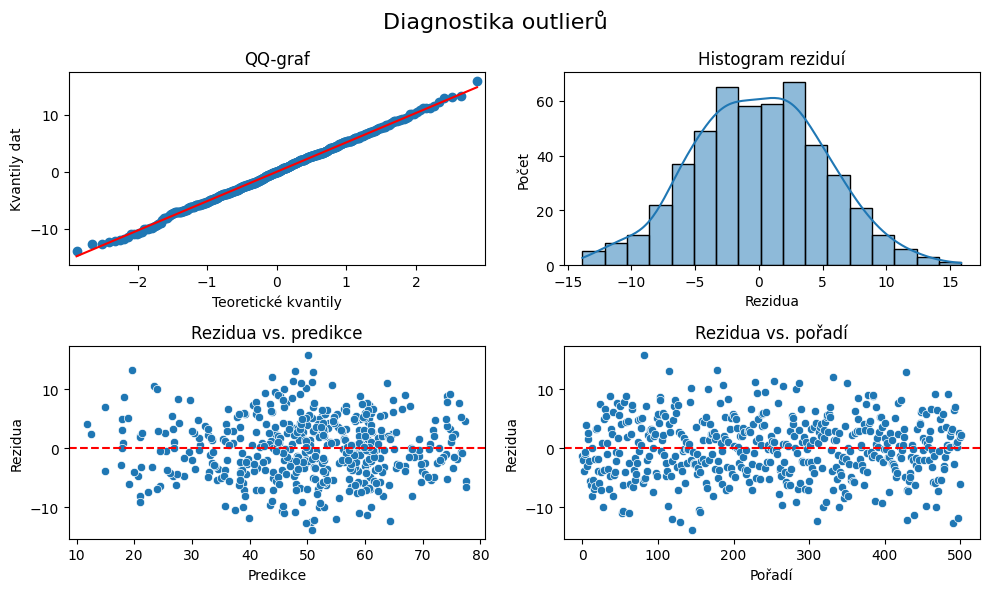

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Diagnostika outlierů", fontsize=16)

sm.qqplot(results2.resid, line="s", ax=axes[0, 0])
axes[0, 0].set_title("QQ-graf")
axes[0, 0].set_xlabel("Teoretické kvantily")
axes[0, 0].set_ylabel("Kvantily dat")

sns.histplot(results2.resid, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Histogram reziduí")
axes[0, 1].set_xlabel("Rezidua")
axes[0, 1].set_ylabel("Počet")

sns.scatterplot(x=results2.fittedvalues, y=results2.resid, ax=axes[1, 0])
axes[1, 0].set_title("Rezidua vs. predikce")
axes[1, 0].set_xlabel("Predikce")
axes[1, 0].set_ylabel("Rezidua")
axes[1, 0].axhline(0, color="red", linestyle="--")

sns.scatterplot(x=df.index, y=results2.resid, ax=axes[1, 1])
axes[1, 1].set_title("Rezidua vs. pořadí")
axes[1, 1].set_xlabel("Pořadí")
axes[1, 1].set_ylabel("Rezidua")
axes[1, 1].axhline(0, color="red", linestyle="--")

plt.tight_layout()
plt.show()

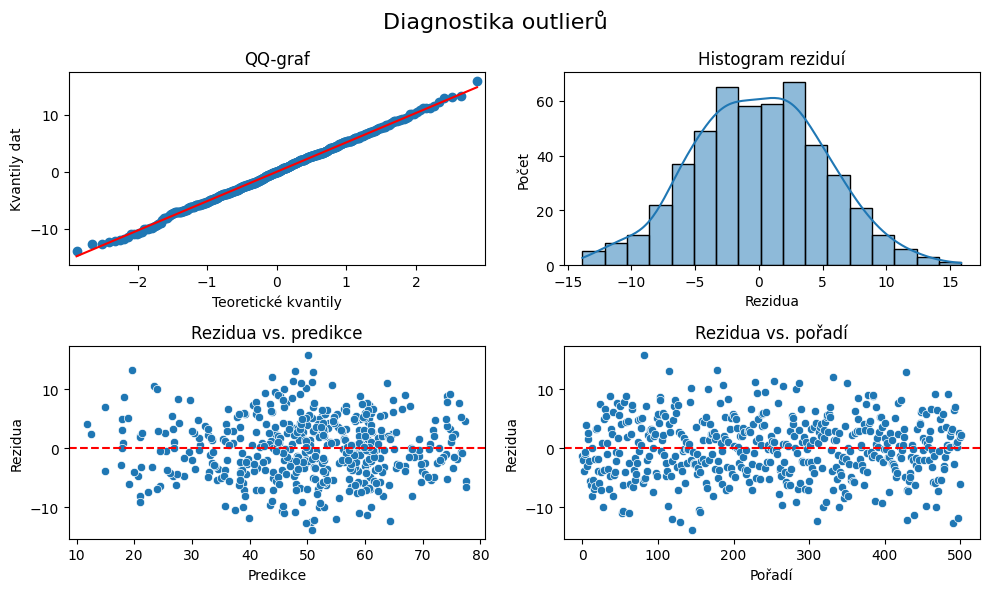

In [8]:

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Diagnostika outlierů", fontsize=16)

sm.qqplot(results2.resid, line="s", ax=axes[0, 0])
axes[0, 0].set_title("QQ-graf")
axes[0, 0].set_xlabel("Teoretické kvantily")
axes[0, 0].set_ylabel("Kvantily dat")

sns.histplot(results2.resid, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Histogram reziduí")
axes[0, 1].set_xlabel("Rezidua")
axes[0, 1].set_ylabel("Počet")

sns.scatterplot(x=results2.fittedvalues, y=results2.resid, ax=axes[1, 0])
axes[1, 0].set_title("Rezidua vs. predikce")
axes[1, 0].set_xlabel("Predikce")
axes[1, 0].set_ylabel("Rezidua")
axes[1, 0].axhline(0, color="red", linestyle="--")

sns.scatterplot(x=df.index, y=results2.resid, ax=axes[1, 1])
axes[1, 1].set_title("Rezidua vs. pořadí")
axes[1, 1].set_xlabel("Pořadí")
axes[1, 1].set_ylabel("Rezidua")
axes[1, 1].axhline(0, color="red", linestyle="--")

plt.tight_layout()
plt.show()

In [9]:
n_samples = 1000000

interact_samples = np.random.uniform(
    df["interact"].min(), df["interact"].max(), n_samples)
actusers_samples = np.random.uniform(
    df["actusers"].min(), df["actusers"].max(), n_samples)
os_samples = np.random.choice(df["os"].unique(), n_samples)

sample_data = pd.DataFrame({
    "interact": interact_samples,
    "actusers": actusers_samples,
    "os": os_samples
})

sample_data["predicted_ping"] = results.predict(sample_data)

max_values = sample_data.loc[sample_data["predicted_ping"].idxmax()]

print(f"Max ping: {max_values["predicted_ping"]}")
print("Parametry:")
print(f"interact: {max_values["interact"]}")
print(f"actusers: {max_values["actusers"]}")
print(f"os: {max_values["os"]}")

Max ping: 77.58890702509396
Parametry:
interact: 0.9979258560200266
actusers: 9787.758662800725
os: MacOS


In [ ]:
prediction_data = pd.DataFrame({
    "interact": [df["interact"].mean()],
    "actusers": [df["actusers"].mean()],
    "os": ["Windows"]
})

predictions = results.get_prediction(prediction_data)
summary_frame = predictions.summary_frame(alpha=0.05)
print(f"Mean ping: {summary_frame["mean"].iloc[0]:.4f}")
print(f"Conf. interval: <{summary_frame["mean_ci_lower"].iloc[0]:.4f}, {
      summary_frame["mean_ci_upper"].iloc[0]:.4f}>")
print(f"Pred. interval: <{summary_frame["obs_ci_lower"].iloc[0]:.4f}, {
    summary_frame["obs_ci_upper"].iloc[0]:.4f}>")

Mean ping: 55.0027
Conf. interval: <53.9721, 56.0332>
Pred. interval: <44.7247, 65.2807>
